# ICS 235 Homework Assignment 2
# <span style="color:red">Due: 11:55 PM on Monday, October 7</span>

## Instructions

1. Name your notebook file using your last and first name as presented in Laulima.
    - For example, Harry, Potter ==> HarryPotter_2.ipynb (The number at the end is the assignment number.)
2. Only use .ipynb file extensions. Other extensions (file formats) like .rtf, .zip, .docs, .pdf are not accepted.
3. Data files will be available to the instructor, so no need to upload them to Laulima. Make sure you use the same filenames of data files as given in the homework.
4. Save data files in **"data" folder under your working directory**. Use **relative path** when you read in data in your code.
5. Do not create any subfolders in your Drop Box.
6. **Do not modify or delete the provided code unless instructed to do so.**
7. Clean your code before submission.
    - If needed, provide clear documentation describing the purpose and how to use every class or function in your code.
    - Your submission should **show only the required outputs**. 
8. Run your code before submission to **show all outputs in the submitted file**. 
10. Write your full name in the cell below.
***

## Your Name: Anne Dominique Malig
***

# Exercise 1: Regularization (65 points)

## About the data

For this exercise, we will analyze a dataset of Computed Tomography (CT) scans, modified for the purpose of this assignment. A CT scan combines a series of X-ray measurements taken from different angles around your body and uses computer processing to create cross-sectional images (slices) of the bones, blood vessels and soft tissues inside your body ([wikipedia](https://en.wikipedia.org/wiki/CT_scan)). Due to various reasons, the physician does not always know which part of the body a slice corresponds to (see [this paper](https://www.researchgate.net/profile/Ales-Popovic/publication/283342504_Prediction_of_relative_position_of_CT_slices_using_a_computational_intelligence_system/links/5c3a600b299bf12be3c3c937/Prediction-of-relative-position-of-CT-slices-using-a-computational-intelligence-system.pdf) for more details). Our goal is to develop a machine learning algorithm that can assist the physician in localizing the location of slices within the body of the patient.

A  specific description for this dataset is available on the [UCI website](https://archive.ics.uci.edu/ml/datasets/Relative+location+of+CT+slices+on+axial+axis#):

> The data was retrieved from a set of 53,500 CT images from 74 different
patients (43 male, 31 female).<br/>
Each CT slice is described by two histograms in polar space.
The first histogram describes the location of bone structures in the image,
the second the location of air inclusions inside of the body.
Both histograms are concatenated to form the final feature vector.
Bins that are outside of the image are marked with the value -0.25.<br/>
The class variable (relative location of an image on the axial axis) was
constructed by manually annotating up to 10 different distinct landmarks in
each CT Volume with known location. The location of slices in between
landmarks was interpolated.

| Column range | Description                                      |
|--------------|--------------------------------------------------|
|      0       | patient id                                       |
|      1       | Relative location of the image on the axial axis |
|    2-241     | Histogram describing bone structures             |
|  242-385     | Histogram describing air inclusions              |

## Getting started

We can load the data as usual with the pandas library.

In [1]:
import pandas as pd

ct_data = pd.read_csv("data/slice_localization.csv", index_col=0)
ct_data.head()

,location,bone_struct_1,bone_struct_2,bone_struct_3,bone_struct_4,bone_struct_5,bone_struct_6,bone_struct_7,bone_struct_8,bone_struct_9,...,air_inclusion_135,air_inclusion_136,air_inclusion_137,air_inclusion_138,air_inclusion_139,air_inclusion_140,air_inclusion_141,air_inclusion_142,air_inclusion_143,air_inclusion_144
patient_id,,,,,,,,,,,,,,,,,,,,,
0,35.637780,0.000000,0.000000,0.0,0.0,0.886814,0.350000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.999530,0.999919,1.0,0.991363,0.0,0.0,-0.25
0,27.500175,0.285199,0.000000,0.0,0.0,0.000000,0.948412,0.990161,0.974925,0.186741,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00
0,29.825205,0.386293,0.312139,0.0,0.0,0.000000,0.770162,0.937115,0.953119,0.980818,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00
0,35.870283,0.000000,0.000000,0.0,0.0,0.837209,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.999316,0.999891,1.0,0.994250,0.0,0.0,-0.25
0,25.407648,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.25


We also extract our feature and target arrays, where:

- The features (X) are the histogram values for both the bone structure and air inclusion.
- The target (y) is the relative location of the slice on the axial axis in the range \[0,180\] where 0 denotes the top of the head and 180 the soles of the feet.

In [2]:
X = ct_data.drop(columns="location")
y = ct_data["location"]

print(X.shape, y.shape)

(485, 384) (485,)


We will now split the data into train and test set. We select 80% of patients to be in the training set, and 20% in the test set.

In [3]:
import numpy as np

np.random.seed(42)

patients = X.index.unique()
train_patients = np.random.choice(patients, int(0.8*len(patients)), replace=False)
test_patients = np.setdiff1d(patients, train_patients)

X_train = X.loc[train_patients]
y_train = y.loc[train_patients]
X_test = X.loc[test_patients]
y_test = y.loc[test_patients]

## Questions

1. Do we need to scale the features or not? Why? (*Hint: Note what the feature values represent.*) (5 points)

> **YOUR ANSWER**: No, the features don't need to be scaled because the numerical values of bone structure and air inclusion are on fairly similar scales.

2. Build a plain linear regression model without regularization to predict the slice location. (Use default values for the arguments of the model.) What is the coefficient of determination, $R^2$, for the train and test data? (6 points)

In [4]:
# YOUR CODE
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print(f'Train score: {lin_reg.score(X_train, y_train):.3f}')
print(f'Test score: {lin_reg.score(X_test, y_test):.3f}')


Train score: 0.990
Test score: -4.322


3. To improve the fit, we want to add regularization. (7 points)
    1. What does regularization consist in in the case of linear regression models?
    2. Describe the difference between L1 and L2 regularization.

> **YOUR ANSWER**:
>
> A. In the case of linear regressionmodels, regularization reduces the risk of overfitting the training set by using penalty terms to discourage large coefficients and constraining the weights of the model.
>
> B. L1 regularization has a penalty sum of the norm of w. (Norm already includes the sum.) While L2 regularization has a penalty sum of the dot product of w. (Dot product already includes the sum.)

4. Build a regularized linear regression model with L1 regularization (choose $\alpha$ = 0.1) to predict the slice location. What is the coefficient of determination, $R^2$, for the test data? (5 points)

In [5]:
# YOUR CODE
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

lasso = Lasso(alpha=0.1).fit(X_train, y_train)

print(f'Test score: {lasso.score(X_test, y_test):.3f}')

Test score: 0.782


5. Hyperparameter tuning:
    1. Use a 5-fold cross-validation approach to test a range of values for the regularization parameter $\alpha$. Use the range [0.01, 0.3] with a step size of 0.01. (12 points)
    2. Plot the mean validation coefficient of determination, $R^2$, (for all folds) as a function of $\alpha$. Label each axis properly. (5 points)
    3. What is the best value of $\alpha$? Fit the model with the best $\alpha$ value to the entire training set and print the coefficient of determination, $R^2$, on the test set. (5 points)

    Note: You might encounter some convergence warnings for some values of $\alpha$. Feel free to ignore them. (Or you can increase `max_iter` value.)

Test score with Best Value of alpha: 0.812
Best Value of alpha: 0.06


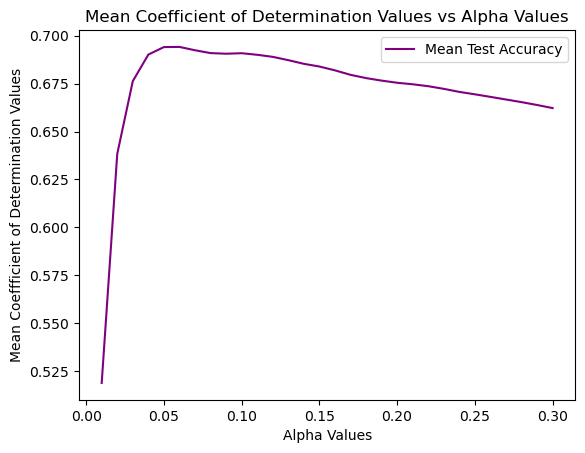

In [6]:
# YOUR CODE

# 5.A
import numpy as np
from sklearn.model_selection import cross_val_score

alpha_range = np.arange(0.01, 0.31, 0.01)
cv_scores = []

for alpha in alpha_range:
    model = Lasso(alpha=alpha, max_iter=1000000)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores.append(np.mean(score))
# 5.B
import matplotlib.pyplot as plt

plt.plot(alpha_range, cv_scores, color = "purple", label = "Mean Test Accuracy")
plt.title("Mean Coefficient of Determination Values vs Alpha Values")
plt.xlabel("Alpha Values")
plt.ylabel("Mean Coeffficient of Determination Values")
plt.legend()
# 5.C
best_alpha = alpha_range[np.argmax(cv_scores)]
new_lasso = Lasso(alpha=best_alpha).fit(X_train, y_train)
print(f'Test score with Best Value of alpha: {new_lasso.score(X_test, y_test):.3f}')
print(f'Best Value of alpha: {best_alpha:.2f}')



6. Why is the score decreasing after $\alpha$ reaches a certain value in the plot from Question 5.B? (5 points)

> **YOUR ANSWER**: $\alpha$ controls the regularization strength: the higher its value the simpler the model becomes. Thus, at some point, the model starts to underfit the training data and not enough features are taken into account. In other words, the optimization algorithm becomes too much focused on the coefficients penalty rather than trying to minimize the difference between the prediction and the target values.
> 

7. To visually compare the models trained with and without regularization, make two scatterplots side-by-side (subplots) in a single plot showing the predicted values against the true target values for test set for the linear regression model without regularization from Question 2 and the best regularized model found in Question 5. Add a red dotted line (x, x) to show the deviation from the true value. **Use the same axes ranges for both subplots**. (15 points)

   - x-axis should be the true target value and the y-axis should be the predicted value. Label the axes accordingly.
   - Provide an appropriate title for each subplot.

Text(0, 0.5, 'Predicted Values')

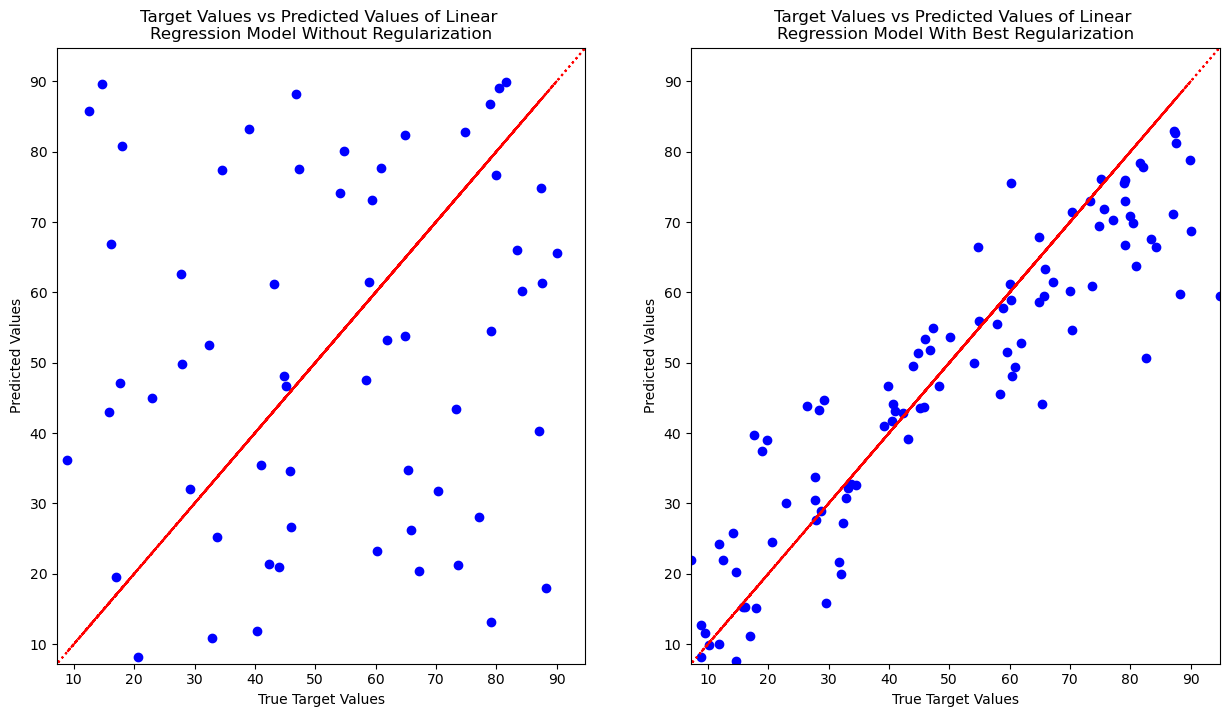

In [7]:
# YOUR CODE
y_pred_lin_reg = lin_reg.predict(X_test)
y_pred_lasso = new_lasso.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(15,8))

axs[0].scatter(y_test, y_pred_lin_reg, color="blue")
axs[0].plot(y_test, y_test, color="red", linestyle=':')
axs[0].set_xlim(np.min(y_test), np.max(y_test))
axs[0].set_ylim(np.min(y_test), np.max(y_test))
axs[0].set_title('Target Values vs Predicted Values of Linear \nRegression Model Without Regularization')
axs[0].set_xlabel('True Target Values')
axs[0].set_ylabel('Predicted Values')

axs[1].scatter(y_test, y_pred_lasso, color="blue")
axs[1].plot(y_test, y_test, color="red", linestyle=':')
axs[1].set_xlim(np.min(y_test), np.max(y_test))
axs[1].set_ylim(np.min(y_test), np.max(y_test))
axs[1].set_title('Target Values vs Predicted Values of Linear \nRegression Model With Best Regularization')
axs[1].set_xlabel('True Target Values')
axs[1].set_ylabel('Predicted Values')

# Exercise 2: Predicting Beach Volleyball Games Outcome

## About the data

This exercise is based on beach volleyball games from international games (FIVB) or in the US (AVP). This is a public dataset from [kaggle](https://www.kaggle.com/jessemostipak/beach-volleyball) that was cleaned for our purpose. As usual, you have a data table with samples as rows and features as columns.

The data is organized the following way:
- There are two rows for each game: one row for the winning team and one row for the losing team.
- Each team is composed of two players. Characteristics and stats of players are averaged to provide a global value for the team.
 
The features are:

| feature name    | values      | description                                |
|-----------------|-------------|--------------------------------------------|
| outcome         | W or L      | Win or Loss                                |
| duration        | int         | Duration of the game in minutes            |
| year            | int         | Tournament year                            |
| nb_sets         | 2 or 3      | Number of sets                             |
| avg_score_diff  | float       | Average score difference in all sets       |
| team_age        | float       | Average age of the two players             |
| team_gender     | W or M      | Team gender                                |
| team_height     | float       | Average height of the two players          |
| team_tot_{stat} | float       | Average {stat} for both players            |

## Loading the data

We first need to load the dataset.

In [8]:
import pandas as pd

vb_matches = pd.read_csv("data/vb.csv")
vb_matches.head()

,year,team_gender,duration,nb_sets,avg_score_diff,outcome,team_age,team_height,team_tot_aces,team_tot_attacks,team_tot_blocks,team_tot_digs,team_tot_errors,team_tot_hitpct,team_tot_kills,team_tot_serve_errors
0,2004,M,24,2.0,10.5,L,31.55,75.0,0.5,17.5,1.0,2.5,2.5,0.12,7.0,2.0
1,2004,M,24,2.0,10.5,W,30.71,75.5,0.0,12.5,4.5,4.0,1.0,0.62,8.5,1.0
2,2004,M,27,2.0,7.0,L,24.51,77.0,0.0,19.5,1.0,4.0,6.0,0.25,10.0,3.5
3,2004,M,27,2.0,7.0,W,33.83,77.0,2.0,14.5,2.0,2.5,1.5,0.61,9.5,2.5
4,2004,M,29,2.0,8.0,L,27.69,74.5,0.5,20.5,1.0,1.5,6.5,0.28,11.5,3.0


We can now organize our data into features and target:

    - Our target variable (y) will be the "outcome" column.
    - Our features (X) are all of the other columns.

In [9]:
X = vb_matches.drop(columns="outcome")
y = vb_matches["outcome"]

## Part 1: Preparing the data for analysis (10 points)

We first need to make sure the data is properly formatted and normalized to build our predictive model. These preparation steps include (among others):
   
- Setting aside test samples to test our model later
- Converting any categorical variables into numerical values
- Normalizing the numeric variables to make the ranges of values similar

### Questions

1. Before we work on the dataset, we need to split our data into training and testing. Using the scikit-learn library, split the data into 70% training and 30% testing. In order to make the results consistent for everyone, use a random state of 42. (1 point)

In [10]:
# YOUR CODE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)

2. Which feature(s) are numerical and which are categorical? (You can answer this question by inspecting the data. No need to write a code.) (2 points)

>**YOUR ANSWER**:
>
> - Numerical features: year, duration, nb_sets, avg_score_diff, team_age, team_height, team_tot_aces, team_tot_attacks, team_tot_blocks, team_tot_digs, team_tot_errors, team_tot_hitpct, team_tot_kills, team_tot_serve_errors
> - Categorical features: team_gender

3. **Standardize** the *numerical* features identified in Question 2 for both training and testing sets. Don't forget that the scaler needs to be fit only on the training data. (4 points)

In [11]:
# pd.options.mode.chained_assignment = None    # ignore some potential warnings for this question

# YOUR CODE
from sklearn.preprocessing import StandardScaler

numerical_features = ['year', 'duration', 'nb_sets', 'avg_score_diff', 'team_age', 'team_height', 'team_tot_aces', 'team_tot_attacks', 'team_tot_blocks', 'team_tot_digs', 'team_tot_errors', 'team_tot_hitpct', 'team_tot_kills', 'team_tot_serve_errors']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler().fit(X_train[numerical_features])
X_train_scaled[numerical_features] = scaler.transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print(X_train_scaled)

           year team_gender  duration   nb_sets  avg_score_diff  team_age  \
2770  -1.082782           W  0.695277  1.211939       -0.430634  0.461592   
11591  0.276226           W -1.156755 -0.825124       -0.317504 -0.503680   
2329  -1.082782           W -0.925251 -0.825124       -0.317504 -0.199315   
9628  -0.176777           W -0.693747 -0.825124        0.025313 -0.396428   
11495  0.276226           M  0.155101  1.211939       -1.688771 -1.935646   
...         ...         ...       ...       ...             ...       ...   
11284  0.049725           W  0.926780  1.211939       -1.459084 -0.564553   
11964  0.729229           M -1.233923 -0.825124        2.082213 -1.634180   
5390  -0.629779           M  1.081116  1.211939       -0.204375  0.365934   
860   -1.309284           W -0.925251 -0.825124        1.739396 -0.422516   
15795  1.861736           M -1.311091 -0.825124       -0.146096 -1.095018   

       team_height  team_tot_aces  team_tot_attacks  team_tot_blocks  \
277

4. Convert the *categorical* feature(s) identified in Question 2 to numerical values so that "W" corresponds to 1 and "M" to 0. (You don't need to use an encoder for this conversion.) (3 points)

In [12]:
# YOUR CODE
X_train_scaled['team_gender'] = X_train_scaled['team_gender'].map({'W': 1, 'M': 0})
X_test_scaled['team_gender'] = X_test_scaled['team_gender'].map({'W': 1, 'M': 0})
X_train_scaled['outcome'] = y_train.map({'W': 1, 'L': 0})
X_test_scaled['outcome'] = y_test.map({'W': 1, 'L': 0})

## Part 2: Predicting the winner (25 points)

Now that our data is ready, we can build our predictive model. We want to predict if a team won (column `outcome`) based on the features.

1. Between a linear regression and a logistic regression model, which one is more appropriate for this problem? Why? (2 points)

> **YOUR ANSWER**: Logistic regression is more appropriate for this problem because the possible values are either 0 or 1, or L or W, and the predicted value of logistic regression is in between 0 or 1.

2. Fit a logistic regression model **without regularization** to predict the outcome of the game and compute the accuracy on the test set. (8 points)

In [13]:
# YOUR CODE
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train_scaled, y_train)

print(f'Test accuracy: {log_reg.score(X_test_scaled, y_test):.3f}')

y_pred = log_reg.predict(X_test_scaled)
prediction_df = X_test_scaled.copy()
prediction_df['prediction'] = y_pred
print(prediction_df)

Test accuracy: 1.000
           year  team_gender  duration   nb_sets  avg_score_diff  team_age  \
4894  -0.629779            0 -0.693747 -0.825124        0.196721 -0.642819   
3903  -0.856281            1 -1.388259 -0.825124        0.196721 -0.054379   
744   -1.309284            1 -1.233923 -0.825124        0.539538 -1.422573   
12608  0.729229            1 -0.385075  1.211939        0.138442 -3.503852   
5556  -0.629779            0  1.775628  1.211939       -0.430634 -0.399327   
...         ...          ...       ...       ...             ...       ...   
13413  0.955731            1  0.077933  1.211939        0.138442 -0.100759   
12480  0.729229            1 -0.925251 -0.825124       -0.488912 -1.164588   
16756  2.088238            0  1.852796  1.211939       -1.232825  2.180531   
16431  1.861736            1  0.000765 -0.825124       -0.488912 -0.639920   
7600  -0.403278            1 -1.156755 -0.825124        1.567988  0.020987   

       team_height  team_tot_aces  team_to

3. Retrieve the coefficients of the model. What are the **five most significant features** to predict the outcome? List the feature name and the corresponding coefficient value for each of the five features in descending order according to the *absolute value* of the coefficients. (15 points)
   - Hint: You can access the feature names by using the `.columns` attribute of the feature DataFrame. 

In [14]:
# YOUR CODE
feature = X_train_scaled.columns
coefficient = log_reg.coef_[0]

feature_and_coefficient = pd.DataFrame({'Feature': feature, 'Coefficient': coefficient})
feature_and_coefficient_abs = feature_and_coefficient['Coefficient'].abs()
print(feature_and_coefficient)

indices = feature_and_coefficient.loc[feature_and_coefficient_abs.nlargest(5).index]
for index, row in indices.iterrows():
    print(f'Feature: {row['Feature']}, Coefficient: {row['Coefficient']:.2f}')

                  Feature  Coefficient
0                    year    -0.054730
1             team_gender    -1.927738
2                duration    -0.255140
3                 nb_sets    -0.054961
4          avg_score_diff     0.441262
5                team_age     0.115493
6             team_height    -0.782650
7           team_tot_aces     0.429035
8        team_tot_attacks    -0.536455
9         team_tot_blocks     0.519215
10          team_tot_digs     0.422754
11        team_tot_errors     0.008426
12        team_tot_hitpct    -0.023574
13         team_tot_kills     0.623665
14  team_tot_serve_errors    -0.219763
15                outcome    17.393988
Feature: outcome, Coefficient: 17.39
Feature: team_gender, Coefficient: -1.93
Feature: team_height, Coefficient: -0.78
Feature: team_tot_kills, Coefficient: 0.62
Feature: team_tot_attacks, Coefficient: -0.54
